# Gene sorting by KEGG functional annotations (TreeMap)
This notebook is based on the paper *OmicsMapNet: Transforming omics data to take advantage of Deep Convolutional Neural Network for discovery*, whose authors are *Shiyong Ma, Zhen Zhang* (https://arxiv.org/ftp/arxiv/papers/1804/1804.05283.pdf)
- Paper summary: 
Their aim was to rearrange high-dimensional omics data as 2-dimensional images, and train a Keras-CNN with them. For that, they used KEGG database which provides functional anotation of genes. Specifically, KEGG BRITE captures 'the functional hierarchies of biological objects'. And based on this hierarchy, each omic vector was shaped as an image using a treemap.

In [1]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import squarify 

###  KEGG and TCGA data loading

- Data coming from KEGG database is fetched on 'KEGG_Data_obtaining.ipynb' notebook
- Data coming from TCGA database is fetched on 'TCGA_Data_obtaining.ipynb' notebook

In [2]:
# KEGG
hsa = pd.read_csv('data/KEGG/KEGG_gene_hsa.csv', sep='\t'  , engine='python', header=None, index_col=0)
hsa_brite = pd.read_csv('data/KEGG/KEGG_hsa_brite.csv', sep='\t'  , engine='python', header=None)
hsa_brite.columns = ['keggBriteId', 'keggId']
brite = pd.read_csv('data/KEGG/KEGG_brite.csv', engine='python', header=0, index_col=0)

# TCGA
pp_df_gene_exp = pd.read_hdf("data/preprocessed1_expr.h5", key='expression') # only selected features
df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

In [3]:
brite

,Functional Annotation Group,Functional Annotation Subgroup,keggBriteId,Functional Annotation
0,Pathway and Brite,Pathway maps,8901,KEGG pathway maps
1,Pathway and Brite,Brite files,8902,BRITE hierarchy files
2,Pathway and Brite,Brite files,8904,BRITE table files
3,Pathway and Brite,Networks,8907,KEGG networks
4,Genes and Proteins,Orthologs and modules,0001,KEGG Orthology (KO)
5,Genes and Proteins,Orthologs and modules,0002,KEGG modules
6,Genes and Proteins,Orthologs and modules,0003,KEGG reaction modules
7,Genes and Proteins,Protein families: metabolism,1000,Enzymes
8,Genes and Proteins,Protein families: metabolism,1001,Protein kinases
9,Genes and Proteins,Protein families: metabolism,1009,Protein phosphatases and associated proteins


In [4]:
hsa_brite['keggBriteId'] = [br_id[7:] for br_id in hsa_brite['keggBriteId']]

In [5]:
brite_homosap_index = list(set(brite['keggBriteId']).intersection(set(hsa_brite['keggBriteId'])))

In [6]:
brite = brite.loc[brite['keggBriteId'].isin(brite_homosap_index)]

In [7]:
pp_ens_genes = pp_df_gene_exp.columns
ens_genes = df_gene_exp.columns

In [8]:
len(ens_genes)

60498

In [9]:
len(pp_ens_genes)

5331

In [10]:
# save memory
del pp_df_gene_exp

## MAPPING: From Ensembl Gene ID to KEGG BRITE functional annotation
KEGG relates Hugo-gene-names to an internal id (KEGG id) that is useful to find out the corresponding KEGG BRITE value/s (hierarchical functional annotations) of each gene.
Due to genes in TCGA are indexed by Ensembl-ids, it is needed mapping Ensembl-id to Hugo-gene-name

All the code below (mappings) can be ignored until next section just loading 'gene_mapping' DataFrame, which contains mapping from Ensembl id to KEGG Brite

In [11]:
# Loading 'gene_mapping' DataFrame
gene_mapping = pd.read_hdf('data/KEGG/map_ens_kegg_brite.h5', key='map')

### Mapping: Ensembl Gene ID to  Hugo Gene Name
Down below, it is downloaded a table relating ensembl-ids and hugo-gene-names from this URL: https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv

In [77]:
%%time

url = 'https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv'
hugo_request = requests.get(url, allow_redirects=True)
open('data/hugo_ensembl.tsv', 'wb').write(hugo_request.content)
del hugo_request

CPU times: user 121 ms, sys: 128 ms, total: 249 ms
Wall time: 3.95 s


In [78]:
hugo_ens = pd.read_csv('data/hugo_ensembl.tsv', sep='\t', engine='python', index_col=0)

In [79]:
hugo_ens = hugo_ens[~hugo_ens.index.duplicated()]

common_genes = hugo_ens.index.intersection(ens_genes)
hugo_ens = hugo_ens.loc[common_genes, :]

len(common_genes)

60448

In [80]:
hugo_ens

,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000456328.2,DDX11L1-002,processed_transcript,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000362751.1,NaN,2,pseudo
ENSG00000227232.5,WASH7P,unprocessed_pseudogene,KNOWN,ENST00000488147.1,WASH7P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000000958.1,OTTHUMT00000002839.1,NaN,2,pseudo
ENSG00000278267.1,MIR6859-1,miRNA,KNOWN,ENST00000619216.1,MIR6859-1-201,miRNA,KNOWN,NaN,NaN,NaN,3,nonCoding
ENSG00000243485.3,RP11-34P13.3,lincRNA,KNOWN,ENST00000473358.1,RP11-34P13.3-001,lincRNA,KNOWN,OTTHUMG00000000959.2,OTTHUMT00000002840.1,NaN,2,nonCoding
ENSG00000274890.1,MIR1302-2,miRNA,KNOWN,ENST00000607096.1,MIR1302-2-201,miRNA,KNOWN,NaN,NaN,NaN,3,nonCoding
ENSG00000237613.2,FAM138A,lincRNA,KNOWN,ENST00000417324.1,FAM138A-001,lincRNA,KNOWN,OTTHUMG00000000960.1,OTTHUMT00000002842.1,NaN,2,nonCoding
ENSG00000268020.3,OR4G4P,unprocessed_pseudogene,KNOWN,ENST00000606857.1,OR4G4P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000185779.1,OTTHUMT00000471235.1,NaN,2,pseudo
ENSG00000240361.1,OR4G11P,unprocessed_pseudogene,KNOWN,ENST00000492842.1,OR4G11P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000001095.2,OTTHUMT00000003224.2,NaN,2,pseudo
ENSG00000186092.4,OR4F5,protein_coding,KNOWN,ENST00000335137.3,OR4F5-001,protein_coding,KNOWN,OTTHUMG00000001094.1,OTTHUMT00000003223.1,CCDS30547.1,2,coding
ENSG00000238009.6,RP11-34P13.7,lincRNA,KNOWN,ENST00000466430.5,RP11-34P13.7-001,lincRNA,KNOWN,OTTHUMG00000001096.2,OTTHUMT00000003225.1,NaN,2,nonCoding


In [81]:
gene_mapping = pd.DataFrame(hugo_ens.loc[:,'geneName'])

In [82]:
gene_mapping['ensId'] = gene_mapping.index

In [83]:
gene_mapping['geneName']

ENSG00000223972.5           DDX11L1
ENSG00000227232.5            WASH7P
ENSG00000278267.1         MIR6859-1
ENSG00000243485.3      RP11-34P13.3
ENSG00000274890.1         MIR1302-2
ENSG00000237613.2           FAM138A
ENSG00000268020.3            OR4G4P
ENSG00000240361.1           OR4G11P
ENSG00000186092.4             OR4F5
ENSG00000238009.6      RP11-34P13.7
ENSG00000239945.1      RP11-34P13.8
ENSG00000233750.3            CICP27
ENSG00000268903.1     RP11-34P13.15
ENSG00000269981.1     RP11-34P13.16
ENSG00000239906.1     RP11-34P13.14
ENSG00000241860.6     RP11-34P13.13
ENSG00000222623.1        RNU6-1100P
ENSG00000241599.1      RP11-34P13.9
ENSG00000279928.1        FO538757.3
ENSG00000279457.3        FO538757.2
ENSG00000273874.1         MIR6859-2
ENSG00000275135.1        FO538757.1
ENSG00000228463.8        AP006222.2
ENSG00000241670.3         RPL23AP21
ENSG00000236679.2         RPL23AP24
ENSG00000236743.1     RP5-857K21.15
ENSG00000236601.1      RP4-669L17.2
ENSG00000237094.11    RP4-66

### Mapping: Hugo Gene Name to KEGG gene id

In [84]:
hsa_hugo_dict = dict()
for i in range(0, len(hsa)):
    value = hsa.loc[hsa.index[i],1].split(";")[0].split(',')
    if 'uncharacterized' not in value[0] and len(value[0])<20:
        hsa_hugo_dict[hsa.index[i]] = value

In [85]:
len(hsa_hugo_dict)

26988

In [28]:
%%time
hsa_hugo = pd.DataFrame(columns=['keggId','geneName'])
i = 0
for key, values in hsa_hugo_dict.items():
    for ens in values:
        hsa_hugo.loc[i] = [key, ens]
        i+=1

CPU times: user 4min 53s, sys: 125 ms, total: 4min 53s
Wall time: 4min 53s


In [86]:
hsa_hugo.shape

(86160, 2)

In [87]:
gene_mapping = pd.merge(gene_mapping, hsa_hugo, on='geneName')

### Mapping: KEGG gene id to KEGG BRITE id

In [88]:
gene_mapping

,geneName,ensId,keggId
0,DDX11L1,ENSG00000223972.5,hsa:100287102
1,WASH7P,ENSG00000227232.5,hsa:653635
2,WASH7P,ENSG00000226210.3,hsa:653635
3,MIR6859-1,ENSG00000278267.1,hsa:102466751
4,MIR1302-2,ENSG00000274890.1,hsa:100302278
5,FAM138A,ENSG00000237613.2,hsa:645520
6,OR4F5,ENSG00000186092.4,hsa:79501
7,MIR6859-2,ENSG00000273874.1,hsa:102465909
8,OR4F29,ENSG00000278566.1,hsa:729759
9,OR4F16,ENSG00000273547.1,hsa:81399


In [89]:
len(set(hsa_brite['keggId'].value_counts().index).intersection(gene_mapping['keggId']))

13534

In [90]:
gene_mapping = pd.merge(gene_mapping, hsa_brite, on='keggId')

In [91]:
gene_mapping

,geneName,ensId,keggId,keggBriteId
0,OR4F5,ENSG00000186092.4,hsa:79501,0001
1,OR4F5,ENSG00000186092.4,hsa:79501,4030
2,OR4F29,ENSG00000278566.1,hsa:729759,0001
3,OR4F29,ENSG00000278566.1,hsa:729759,4030
4,OR4F16,ENSG00000273547.1,hsa:81399,0001
5,OR4F16,ENSG00000273547.1,hsa:81399,4030
6,NOC2L,ENSG00000188976.10,hsa:26155,0001
7,NOC2L,ENSG00000188976.10,hsa:26155,3009
8,KLHL17,ENSG00000187961.13,hsa:339451,0001
9,KLHL17,ENSG00000187961.13,hsa:339451,4121


### Mapping: KEGG BRITE id to KEGG BRITE functional annotation

In [92]:
gene_mapping = pd.merge(gene_mapping, brite, on='keggBriteId')

In [93]:
brite

,Functional Annotation Group,Functional Annotation Subgroup,keggBriteId,Functional Annotation
4,Genes and Proteins,Orthologs and modules,0001,KEGG Orthology (KO)
7,Genes and Proteins,Protein families: metabolism,1000,Enzymes
8,Genes and Proteins,Protein families: metabolism,1001,Protein kinases
9,Genes and Proteins,Protein families: metabolism,1009,Protein phosphatases and associated proteins
10,Genes and Proteins,Protein families: metabolism,1002,Peptidases
11,Genes and Proteins,Protein families: metabolism,1003,Glycosyltransferases
14,Genes and Proteins,Protein families: metabolism,1004,Lipid biosynthesis proteins
16,Genes and Proteins,Protein families: metabolism,1006,Prenyltransferases
17,Genes and Proteins,Protein families: metabolism,1007,Amino acid related enzymes
18,Genes and Proteins,Protein families: metabolism,0199,Cytochrome P450


In [27]:
gene_mapping

,geneName,ensId,keggId,keggBriteId,Functional Annotation Group,Functional Annotation Subgroup,Functional Annotation
0,OR4F5,ENSG00000186092.4,hsa:79501,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
1,OR4F29,ENSG00000278566.1,hsa:729759,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
2,OR4F16,ENSG00000273547.1,hsa:81399,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
3,NOC2L,ENSG00000188976.10,hsa:26155,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
4,KLHL17,ENSG00000187961.13,hsa:339451,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
5,HES4,ENSG00000188290.10,hsa:57801,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
6,ISG15,ENSG00000187608.8,hsa:9636,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
7,AGRN,ENSG00000188157.13,hsa:375790,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
8,MIR200B,ENSG00000207730.2,hsa:406984,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
9,MIR200A,ENSG00000207607.2,hsa:406983,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)


## Mapping: KEGG BRITE functional annotation to KEGG BRITE group of functional annotations

### Mapping: exporting gene_mapping DataFrame

In [97]:
with pd.HDFStore('data/KEGG/map_ens_kegg_brite.h5') as store:
    store['map'] = gene_mapping

In [96]:
gene_mapping['geneName']

0           OR4F5
1          OR4F29
2          OR4F16
3           NOC2L
4          KLHL17
5            HES4
6           ISG15
7            AGRN
8         MIR200B
9         MIR200A
10         MIR429
11       TNFRSF18
12        TNFRSF4
13           SDF4
14        B3GALT6
15         UBE2J2
16         SCNN1D
17          ACAP3
18         TAS1R3
19           DVL1
20       AURKAIP1
21         MRPL20
22         ATAD3B
23         ATAD3A
24          SSU72
25           MIB2
26         MMP23B
27         CDK11B
28       SLC35E2B
29         CDK11A
           ...   
31974        NOD1
31975      CLEC5A
31976       DDX58
31977        TLR4
31978        TLR7
31979        TLR8
31980        SRP9
31981     SEC61A2
31982       OXA1L
31983       SRP54
31984       SRP14
31985       SRP68
31986     SEC61A1
31987       SRPRB
31988       SEC62
31989       SRP72
31990        DCTD
31991       SRP19
31992       SEC63
31993      SEC61G
31994      SEC61B
31995       EARS2
31996       DNMT1
31997        NFS1
31998     

# TREEMAP

In [49]:
df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

In [50]:
pat1 = pd.DataFrame(df_gene_exp.iloc[0])
pat1['ensId'] = pat1.index
del df_gene_exp

In [58]:
pat1 = pd.merge(gene_mapping, pat1, on='ensId')

In [62]:
pat1.to_csv('pat1.csv')

RecursionError: maximum recursion depth exceeded in comparison

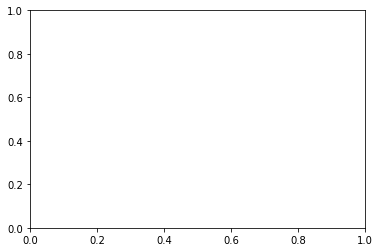

In [61]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=pat1['TCGA-19-1787-01']*10
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors )
plt.axis('off')
plt.show()


In [13]:
first_tree = pd.DataFrame(gene_mapping['Functional Annotation'].value_counts())

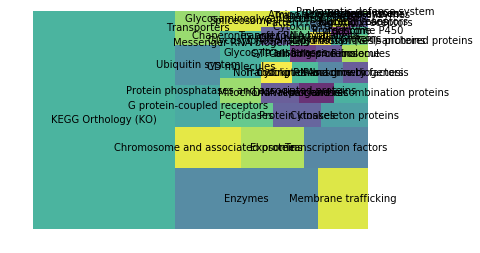

In [18]:
squarify.plot(sizes=first_tree['Functional Annotation'], label=first_tree.index, alpha=.8)
plt.axis('off')
plt.show()

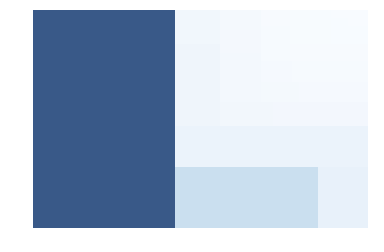

In [18]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=pd.DataFrame(gene_mapping['Functional Annotation'].value_counts())['Functional Annotation']
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors )
plt.axis('off')
plt.show()


In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R 
#-i gene_mapping -w 5 -h 5 --units in -r 200
#gene_mapping$Functional.Annotation.Subgroup
#gene_mapping$Functional.Annotation

#library
install.packages("treemap", 'https://cran.r-project.org')
#library(tre
#installed.packages()

In [9]:
%%R
library(treemap)


Error in library(treemap) : there is no package called ‘treemap’


/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: package ‘treemap’ is not available (for R version 3.5.0) 

  warnings.warn(x, RRuntimeWarning)
/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 2: package ‘treemap’ is not available (for R version 3.5.0) 

  warnings.warn(x, RRuntimeWarning)
/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 3: package ‘treemap’ is not available (for R version 3.5.0) 

  warnings.warn(x, RRuntimeWarning)
